In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/natural-language-processing-with-disaster-tweets/sample_submission.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv



**Competition**

https://www.kaggle.com/competitions/nlp-getting-started

**Code Ref**

https://www.kaggle.com/code/carlosmatherson/nlp-with-disaster-tweets-rnn

**Dataset**

Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


**Introduction**

GitHub: https://github.com/donxiya/NLP-Disaster-Tweets
This project leverages Twitter as a real-time source for disaster reporting but addresses the challenge of distinguishing genuine disaster tweets from figurative or exaggerated language. Using a dataset of 10,000 labeled tweets (real disaster or not), it applies natural language processing (NLP) and a gated recurrent unit (GRU)-based neural network. The notebook covers data exploration, tweet text preprocessing, GRU model building and training, and model fine-tuning for improved performance.

In [2]:
import numpy as np
import pandas as pd
import re
import warnings
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional

warnings.filterwarnings('ignore')

2025-06-15 04:02:42.312571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749960162.589910      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749960162.670972      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

#load data
train_df = pd.read_csv('/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv')
test_df = pd.read_csv('/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv')

In [4]:

#EDA: data shape and column names
print("Training set shape:", train_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())
train_df.sample(10)

Training set shape: (7613, 5)

Training set columns: ['id', 'keyword', 'location', 'text', 'target']


,id,keyword,location,text,target
2676,3838,detonate,Northern Ireland,@SourMashNumber7 @tomfromireland @rfcgeom66 @B...,1
4926,7018,mayhem,"Boston, MA",@alexbelloli well now I know lol,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1
2350,3381,demolition,"Atlantic, IA",Last chance to work at the old FFA foodstand a...,0
5319,7594,outbreak,Pro-American and Anti-#Occupy,#BREAKING 10th death confirmed in Legionnaires...,1
6228,8890,smoke,"Bronx, NY",I just wanna smoke some weed and get some commas,0
507,732,attacked,NaN,I attacked Robot-lvl 19 and I've earned a tota...,0
5151,7345,obliterate,"Dover, DE",@dicehateme @PuppyShogun This makes sense. Pap...,0
2334,3359,demolition,MA,demolition 1 &amp; 2 still the most fire frees...,0
1858,2671,crush,05/04/2014 18:23 ?,@PYDisney que crush?#MTVHottest Justin Bieber,0


Total unique keywords (including NaN): 221



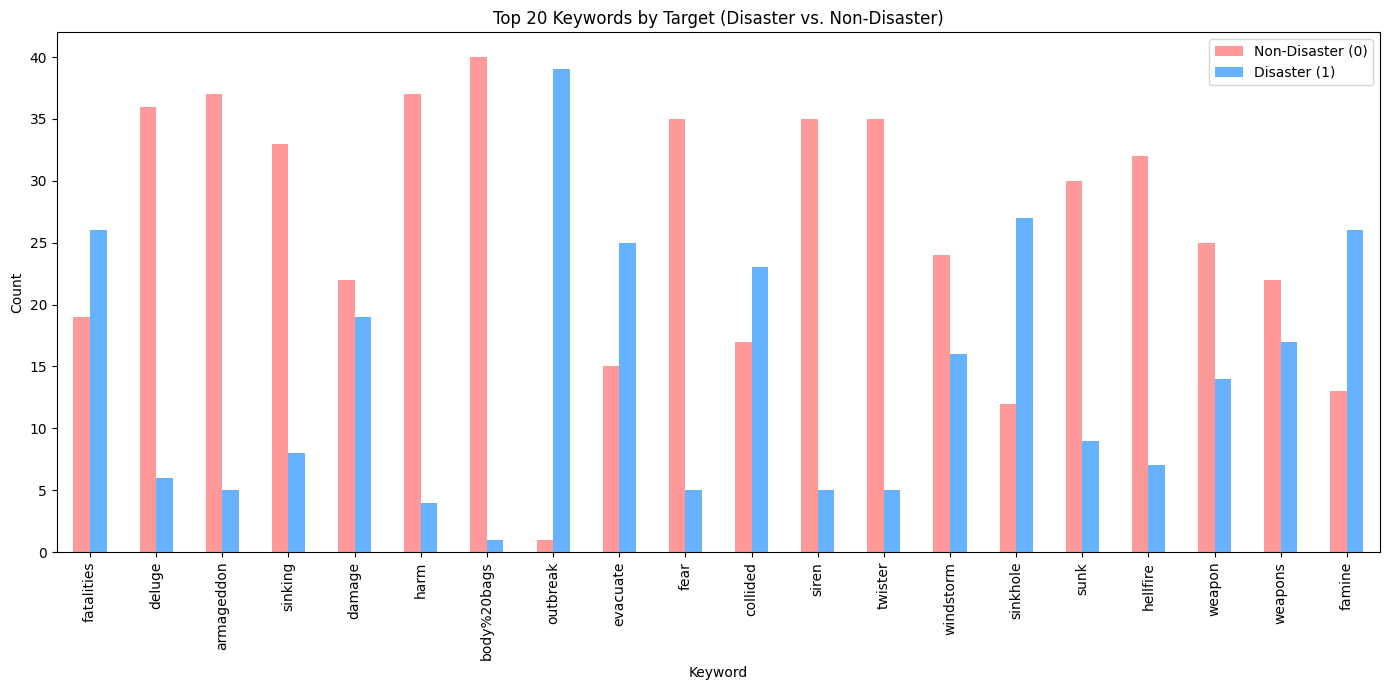

In [5]:

#EDA: 20 most common key words from the training dataset by classes.
#it display that some key appear in both classes.
keyword_target_counts = train_df.groupby(['keyword', 'target']).size().unstack(fill_value=0)

if train_df['keyword'].isna().any():

    if 'unknown' in keyword_target_counts.index:
        keyword_target_counts = keyword_target_counts.rename(index={'unknown': 'NaN'})

top_keywords = keyword_target_counts.sum(axis=1).sort_values(ascending=False).head(20).index

plot_data = keyword_target_counts.loc[top_keywords]

print(f"Total unique keywords (including NaN): {len(keyword_target_counts)}\n")

# plot
fig, ax = plt.subplots(figsize=(14, 7))
plot_data.plot(kind='bar', color=['#FF9999', '#66B2FF'], ax=ax)
plt.title('Top 20 Keywords by Target (Disaster vs. Non-Disaster)')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['Non-Disaster (0)', 'Disaster (1)'])
plt.tight_layout()
plt.show()

Not Disaster (0): 4342 (57.03%)
Disaster (1): 3271 (42.97%)


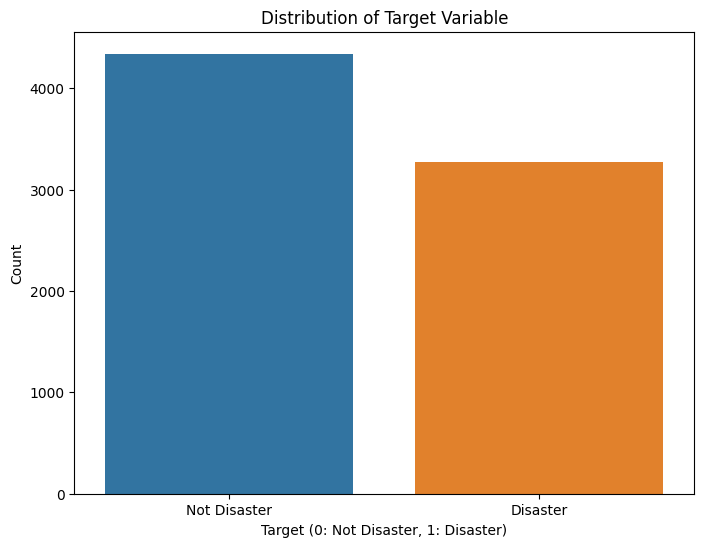

In [6]:

#EDA: Check class distribution
target_counts = train_df['target'].value_counts()
print(f"Not Disaster (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.2f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.2f}%)")

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()

In [7]:

#EDA: clean data by removing links, hashtags, and @usernames
#we also want to remove stop words like: the, is, in that has little meaning
#we are also going to reduce word to base form (like running to run)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = {
    "a", "an", "the", "and", "or", "but", "if", "then", "of", "in", "on", "for", 
    "at", "by", "with", "is", "was", "are", "were", "be", "to", "from", "this", "that"
}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    
    if not isinstance(text, str):
        return ""
    
    # Lowercase and remove unwanted patterns
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+|[^\w\s]|[^\x00-\x7F]+', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    tokens = text.split()

    # Remove stopwords and lemmatize each token
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(cleaned_tokens)
    

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

#remove null values
train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)
test_df['keyword'].fillna('unknown', inplace=True)
test_df['location'].fillna('unknown', inplace=True)

In [8]:

#Tokenize text

max_words = 20000  
max_len = 100      

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train = pad_sequences(train_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)
y_train = train_df['target'].values

In [9]:

#create datasets to load data
BATCH_SIZE = 64

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

def create_dataset(features, labels, batch_size=64, is_training=True):
    
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

train_df = create_dataset(X_train_split, y_train_split, BATCH_SIZE)
val_df = create_dataset(X_val, y_val, BATCH_SIZE, is_training=False)

2025-06-15 04:03:05.247678: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


The GRU is well-suited for text classification because it effectively handles sequential data and avoids the vanishing gradient problem found in standard RNNs. It also offers a good balance between performance and computational efficiency compared to other RNN variants.

This model is a GRU-based neural network designed to classify tweets as real disasters or not. It begins with an embedding layer that transforms input word indices into dense vectors, followed by a SpatialDropout1D layer to reduce overfitting. A bidirectional GRU processes the sequence in both directions to capture contextual information, and its output is normalized using BatchNormalization to stabilize training. A dense layer with ReLU activation adds non-linearity, and the final sigmoid output layer produces a probability indicating whether the tweet reports a real disaster. The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric, striking a balance between performance, efficiency, and generalization.





In [10]:

#build model


def build_gru_model(embedding_dim=128, units=64, dropout=0.2):
    inputs = Input(shape=(max_len,))
    
    x = Embedding(max_words, embedding_dim, input_length=max_len)(inputs)
    x = SpatialDropout1D(dropout)(x)
    x = Bidirectional(GRU(units, dropout=dropout, recurrent_dropout=dropout))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model



In [11]:

# config callbacks for training
def get_callbacks():
    if not os.path.exists('model_checkpoints'):
        os.makedirs('model_checkpoints')
        
    checkpoint_path = 'model_checkpoints/gru_best.keras'
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]
    return callbacks

In [12]:

# Create GRU model
gru_model = build_gru_model(
    embedding_dim=128,
    units=64,
    dropout=0.2
)

# Print model summary
print("\nGRU Model Summary:")
gru_model.summary()

# Get callbacks
callbacks = get_callbacks()


GRU Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,639,169 (10.07 MB)

 Trainable params: 2,638,913 (10.07 MB)

 Non-trainable params: 256 (1.00 KB)

In [13]:

# Train model
print("\nTraining GRU model...")
history = gru_model.fit(
    train_df,
    epochs=10,
    validation_data=val_df,
    callbacks=callbacks,
    verbose=1
)

# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_checkpoints/training_history.csv', index=False)


Training GRU model...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6084 - loss: 0.6571
Epoch 1: val_loss improved from inf to 0.65801, saving model to model_checkpoints/gru_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - accuracy: 0.6091 - loss: 0.6565 - val_accuracy: 0.7925 - val_loss: 0.6580 - learning_rate: 0.0010
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8455 - loss: 0.3726
Epoch 2: val_loss improved from 0.65801 to 0.58886, saving model to model_checkpoints/gru_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.8455 - loss: 0.3725 - val_accuracy: 0.7978 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9029 - loss: 0.2500
Epoch 3: val_loss improved from 0.58886 to 0.50969, saving model to model_checkpoints/gru_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.9028 - loss: 0.2500 - val_accuracy: 0.7807 - val_loss: 0.5097 - learning_rate: 0

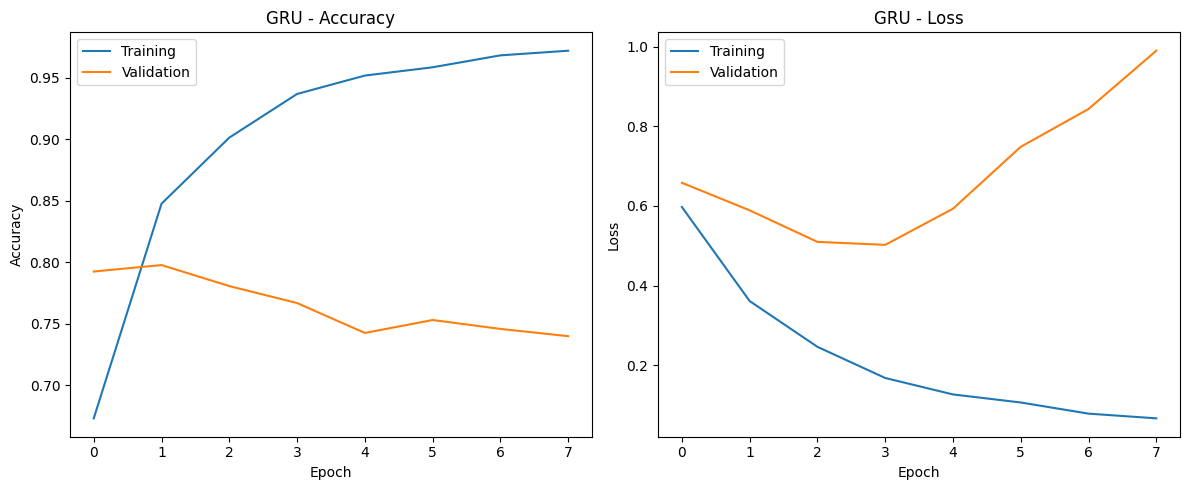

In [14]:

# show learning curves
plt.figure(figsize=(12, 5))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('GRU - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('GRU - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step

GRU Model Evaluation Results:
Validation Accuracy: 0.7669
Validation F1 Score: 0.7271

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.79      0.80      0.80       869
    Disaster       0.73      0.72      0.73       654

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



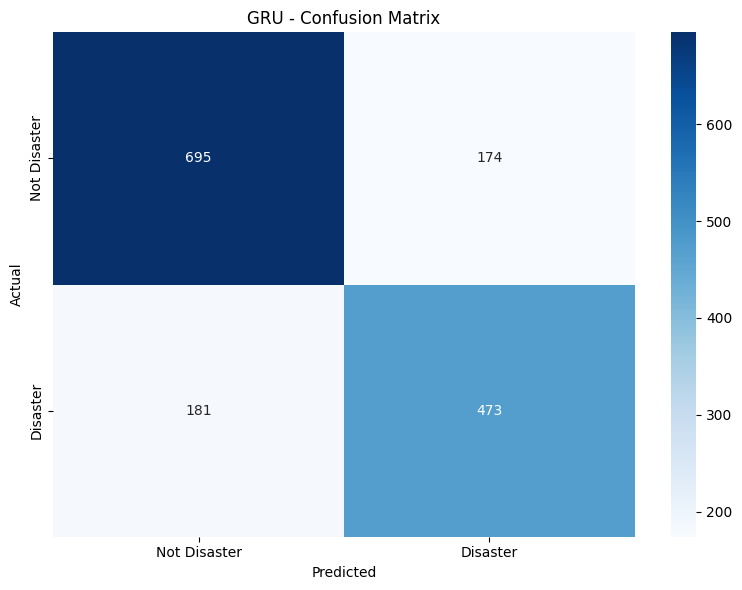

In [15]:

# Evaluate model on validation set
y_pred_proba = gru_model.predict(X_val, batch_size=BATCH_SIZE)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = np.mean(y_pred == y_val)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print("\nGRU Model Evaluation Results:")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Not Disaster', 'Disaster']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('GRU - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [16]:

#Tuning Hyperparameters
hyperparams = [
    {'embedding_dim': 128, 'units': 64, 'dropout': 0.2},   # baseline
    {'embedding_dim': 128, 'units': 128, 'dropout': 0.3},  # increased units, higher dropout
    {'embedding_dim': 256, 'units': 128, 'dropout': 0.5},  # larger embedding, increased units, high dropout
    {'embedding_dim': 256, 'units': 64, 'dropout': 0.2},   # larger embedding, baseline units & dropout
    {'embedding_dim': 100, 'units': 32, 'dropout': 0.1},   # smoller model
    {'embedding_dim': 150, 'units': 150, 'dropout': 0.3}   # equal embedding and units
]
fine_tuned_models = []


for i, params in enumerate(hyperparams):
    print(f"\nTraining model with hyperparameters: {params}")

    # build new model
    model = build_gru_model(
        embedding_dim=params['embedding_dim'],
        units=params['units'],
        dropout=params['dropout']
    )

    # train new model
    model.fit(
        train_df,
        epochs=10,
        validation_data=val_df,
        callbacks=callbacks,
        verbose=1
    )
    
    # eval new model
    y_pred_proba = model.predict(X_val, batch_size=BATCH_SIZE)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    ccuracy = np.mean(y_pred == y_val)
    f1 = f1_score(y_val, y_pred)
    
    fine_tuned_models.append({
        'model': model,
        'params': params,
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    print(f"Model {i+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Training model with hyperparameters: {'embedding_dim': 128, 'units': 64, 'dropout': 0.2}
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6216 - loss: 0.6429
Epoch 1: val_loss did not improve from 0.50220
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.6222 - loss: 0.6424 - val_accuracy: 0.7163 - val_loss: 0.6492 - learning_rate: 0.0010
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8523 - loss: 0.3680
Epoch 2: val_loss did not improve from 0.50220
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.8523 - loss: 0.3679 - val_accuracy: 0.7958 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9177 - loss: 0.2117
Epoch 3: val_loss did not improve from 0.50220
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9176 - loss: 0.2118 - val_accuracy: 0.7774 - val_loss: 0.5112 - learning_rate: 0.0010
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9439 - loss: 0.1554

In [17]:

# pick the best model
best_model_index = np.argmax([m['f1_score'] for m in fine_tuned_models])
best_model = fine_tuned_models[best_model_index]

print(f"\nBest model (model {best_model_index+1}):")
print(f"Parameters: {best_model['params']}")
print(f"Validation Accuracy: {best_model['accuracy']:.4f}")
print(f"Validation F1 Score: {best_model['f1_score']:.4f}")


Best model (model 3):
Parameters: {'embedding_dim': 256, 'units': 128, 'dropout': 0.5}
Validation Accuracy: 0.7669
Validation F1 Score: 0.7464




**Summary and Conclusion**

In this project, a GRU-based neural network was developed to classify tweets as reporting real disasters or not. After experimenting with different hyperparameter settings, Model 3 yielded the best performance by using a larger embedding dimension (256), increased GRU units (128), and higher dropout rate (0.5) for better regularization. This configuration achieved a validation accuracy of 76.69% and an F1 score of 74.64%, indicating a strong balance between precision and recall. The results demonstrate that increasing model capacity and applying aggressive dropout helped the model generalize better to unseen data. Overall, the approach effectively captures semantic and sequential patterns in tweet text, making it a promising method for real-time disaster detection from social media.

In [18]:

# predict on the test set using the best model
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
final_predictions_proba = best_model['model'].predict(test_dataset)

final_predictions = (final_predictions_proba > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created successfully!")
print(submission.head())

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step

Submission file created successfully!
   id  target
0   0       1
1   2       1
2   3       1
3   9       0
4  11       1
